In [46]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Results:
    def __init__(self, measure, dataset_name, model_name, specific_train_route=None, x=4):
        self.dataset_name = dataset_name
        self.model_name = model_name
        self.specific_train_route = specific_train_route
        self.x = x
        self.measure = measure
        self.relative_path = f'Results/Shifted_Runs/{dataset_name}/{model_name}/*results365.csv'
        if self.measure == 'FI':
            self.relative_path = f'Results/Shifted_Runs/{dataset_name}/{model_name}/*feature_importances365.csv'
        
        self.data = self.data_from_files(self.relative_path, self.measure)
        #if measure == 'Error':
        #    self.data = self.data_from_files_error(self.relative_path, self.measure)
        self.data_route = self.extract_train_routes(specific_train_route, self.data)
    
    def data_from_files(self, relative_path, measure):
        file_list_results = glob.glob(relative_path)
        
        result_df = pd.DataFrame()

        for file in file_list_results:
            index_start = len(relative_path.split('*')[0])
            data_from_file = pd.read_csv(file)
            file_dict = {}
            file_dict['route_station'] = file[index_start:].split('_')[0]
            for i in range(1, self.x + 1):
                if measure == 'Error':
                    file_dict[f'{measure}_baseline{i}'] = data_from_file[f'{measure}_baseline{i}'][0]
                    file_dict[f'{measure}_ARIMA{i}'] = data_from_file.get(f'{measure}_ARIMA{i}', [None])[0] # No ARIMA column in only Boosted
                    file_dict[f'{measure}_full{i}'] = data_from_file[f'{measure}_full{i}'][0]
                else:
                    file_dict[f'{measure}_baseline{i}'] = [data_from_file[f'{measure}_baseline{i}']]
                    file_dict[f'{measure}_ARIMA{i}'] = [data_from_file.get(f'{measure}_ARIMA{i}', [None])] # No ARIMA column in only Boosted
                    file_dict[f'{measure}_full{i}'] = [data_from_file[f'{measure}_full{i}']]
                    if measure == 'Predictions':
                        file_dict[f'y_true{i}'] = [data_from_file[f'y_true{i}']]
            result_df = pd.concat([result_df, pd.DataFrame(file_dict, index=[0])], ignore_index=True)
        return result_df
    
    def extract_train_routes(self, specific_train_route, data):
        return data[data['route_station'].str.startswith(f'({specific_train_route},')]
    
    def plot_function():
        print('Not implemented...')
    def plot_caller():
        print('Not implemented')
    

In [47]:
from scipy.stats import wilcoxon
class Errors(Results):
    def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
        super().__init__('Error', dataset_name, model_names, specific_train_route, x)
        
    def error_plot_across_days(self, df):
        df = df.sort_values(by='route_station')
        col_names = np.unique([i[:-1] for i in df.columns[:-1]])
        col_names = col_names[col_names != 'Error_baseline']

        bar_width = 0.2
        num_predictions = self.x  # Assuming self.x holds the number of predictions into the future
        p= 1- 3* bar_width
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        fig, ax = plt.subplots()
        ax.bar(0, df[f'Error_baseline1'], bar_width, label=f'Error_baseline')
        location = []

        for model_name in col_names:
            for i in range(1, num_predictions + 1):
                ax.bar(p + i*bar_width, df[f'{model_name}{i}'], bar_width, color=colors[i-1])
                location += [p + i*bar_width]
            p += 1
        ax.set_xlabel('\nModel and Predicted days')
        ax.set_ylabel('Error')
        ax.set_title('Error Comparison across models')
        ax.set_xticks(location)
        ax.set_xticklabels([i + 1 for i in range(num_predictions)] * len(col_names))
        ax.grid()
        sec = ax.secondary_xaxis(location=0)
        sec_ticks = [0]
        sec_tick_labels = ['\nBaseline']
        for i, model_name in enumerate(col_names):
            sec_ticks.append(i+1 - 1.5 * bar_width)
            sec_tick_labels.append('\n' + model_name.split('_')[-1].capitalize())
        sec.set_xticks(sec_ticks)
        sec.set_xticklabels(sec_tick_labels)
        plt.tight_layout()
        plt.show()

    def error_plot(self, df):
        df = df.sort_values(by='route_station')

        bar_width = 0.25
        index = range(len(df))
        # Plot baseline errors
        plt.bar(index, df['Error_baseline1'], bar_width, label='Baseline')
        # Plot ARIMA errors if available
        displacement = 1
        if 'Error_ARIMA1' in df.columns:
            plt.bar([i + bar_width for i in index], df['Error_ARIMA1'], bar_width, label='ARIMA')
            displacement = 2
        # Plot full errors
        plt.bar([i + displacement*bar_width for i in index], df['Error_full1'], bar_width, label='Full')

        plt.xlabel('(Route, Station)')
        plt.ylabel('Error')
        plt.title('Error comparison for (Route, Station) pairs')

        if displacement == 1:
            plt.xticks([i + bar_width/2 for i in index], df['route_station'])
        else: plt.xticks([i + bar_width for i in index], df['route_station'])

        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.grid()
        plt.show()

    def error_function(self, use_mean=False, use_across_days=False):
        if use_mean or use_across_days:
            mean_errors = pd.DataFrame(self.data.mean(axis=0, numeric_only=True)).T
            mean_errors = mean_errors.assign(route_station='Mean')
            if use_mean:
                self.error_plot(mean_errors)
                return mean_errors
            else:
                self.error_plot_across_days(mean_errors)
        else:
            self.error_plot(self.data_route)

    def median_histogram(self, i=1):
        columns = np.unique([col.split('_')[-1][:-1] for col in self.data.columns if col.startswith('Error')])
        for column_name in columns:
            result_data = self.data[f'Error_{column_name}{str(i)}'] # np.sqrt(result[cv])
            plt.hist(result_data)
            plt.axvline(np.median(result_data), color='red', linestyle='dashed', linewidth=1, label='Median')
            plt.title(f'Error for model={column_name} and i={i}')
            plt.xlabel('MAE')
            plt.ylabel('Occurences')
            plt.legend()
            plt.show()
    

    def latex_table(self, result_matrix, alpha=0.05):
        # Prepare LaTeX table
        latex_table = "\\begin{table}[ht]\n\\centering\n\\begin{tabular}{|" + "c|" * (len(result_matrix.columns) + 1) + "}\n\\hline\n"
        
        # Header row
        latex_table += " & " + " & ".join(result_matrix.columns) + " \\\\\n\\hline\n"
        
        # Data rows
        for i, row_name in enumerate(result_matrix.index):
            latex_table += row_name
            for j, col_name in enumerate(result_matrix.columns):
                if i == j:
                    # Diagonal cell
                    latex_table += " & \\cellcolor[HTML]{cacaca} --"
                else:
                    p_value = float(result_matrix.loc[row_name, col_name])
                    if p_value < alpha:
                        color = "cellcolor[HTML]{e2ffca}"  # Light green
                    else:
                        color = "cellcolor[HTML]{ffbdbd}"  # Light red
                    latex_table += f" & \\{color} {'%.1e' % p_value}"
            latex_table += " \\\\\n\\hline\n"
        
        latex_table += "\\end{tabular}\n\\caption{P-values from Wilcoxon signed-rank tests.}\n\\label{table:results}\n\\end{table}"
        
        print(latex_table)

    def wilcoxon_test(self, specific_model='', i=1, alpha=0.05, name=''):
        model_columns = [col.split('_')[-1] for col in self.data.columns if col.endswith(str(i))]
        if specific_model:
            print(f'Specific model Comparison: {specific_model}')
            model_columns = ['{}{}'.format(specific_model, j) for j in range(1,5)]


        comparisons = [(model_columns[j], model_columns[k]) for j in range(len(model_columns)) for k in range(j + 1, len(model_columns))]

        result_matrix = pd.DataFrame(columns=model_columns, index=model_columns)

        for (model_name1, model_name2) in comparisons:
            differences = np.array(self.data['Error_{}'.format(model_name1)] - self.data['Error_{}'.format(model_name2)])
            rounded_differences = np.round(differences, decimals=5)
            # Perform Wilcoxon signed-rank tests
            statistic, p_value = wilcoxon(rounded_differences)
            #if p_value < alpha:
            #    result_matrix.loc[model_name1, model_name2] = p_value
            #    result_matrix.loc[model_name2, model_name1] = p_value
            result_matrix.loc[model_name1, model_name2] = p_value
            result_matrix.loc[model_name2, model_name1] = p_value

        for model_name in model_columns:
            result_matrix = result_matrix.rename(index={model_name: model_name[0].upper() + ',' + model_name[-1]}, 
                                                 columns={model_name: model_name[0].upper() + ',' + model_name[-1]})
                                                
        result_matrix = result_matrix.applymap(lambda x: '%.1e' % x)
        self.latex_table(result_matrix, alpha=alpha)
        #result_matrix.to_csv(f'Results/Wilcoxon{name}.csv', float_format='%.2e')
        return result_matrix

In [48]:
ARIMA_XGBoost_Errors = Errors('Cleaned', 'ARIMA_XGBoost', 20)
ARIMA_CatBoost_Errors = Errors('Cleaned', 'ARIMA_Catboost', 20)
XGBoost_Errors = Errors('Cleaned', 'XGBoost', 20)
CatBoost_Errors = Errors('Cleaned', 'Catboost', 20)

In [49]:
ARIMA_XGBoost_Errors.data

,route_station,Error_baseline1,Error_ARIMA1,Error_full1,Error_baseline2,Error_ARIMA2,Error_full2,Error_baseline3,Error_ARIMA3,Error_full3,Error_baseline4,Error_ARIMA4,Error_full4
0,"(27, 17)",0.160574,0.122831,0.125385,0.160547,0.130367,0.130812,0.160574,0.130711,0.130420,0.160539,0.131172,0.131150
1,"(5, 12)",0.158921,0.110286,0.110366,0.158989,0.115300,0.116259,0.159059,0.115575,0.114525,0.159065,0.117108,0.118023
2,"(25, 22)",0.112493,0.094265,0.091622,0.112515,0.099185,0.096654,0.112538,0.102745,0.099716,0.112562,0.104881,0.102945
3,"(16, 20)",0.109954,0.098652,0.094429,0.109990,0.105438,0.104877,0.110020,0.104134,0.102510,0.110047,0.106696,0.106048
4,"(4, 39)",0.536239,0.070571,0.044770,0.536406,0.086051,0.062708,0.536564,0.092670,0.067271,0.536691,0.101337,0.077236
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,"(2, 2)",0.189153,0.128141,0.120422,0.189211,0.156213,0.148066,0.189271,0.175080,0.167669,0.189315,0.187852,0.185425
65,"(19, 17)",0.172985,0.111384,0.107628,0.173030,0.126378,0.127570,0.173067,0.132768,0.132467,0.173086,0.137987,0.136645
66,"(11, 16)",0.068887,0.064893,0.067418,0.068894,0.068283,0.067807,0.068897,0.068195,0.066928,0.068891,0.069726,0.070174
67,"(4, 43)",0.536900,0.072053,0.052575,0.537099,0.086686,0.068258,0.537261,0.092894,0.072725,0.537408,0.100717,0.083511


### Test wilcoxon

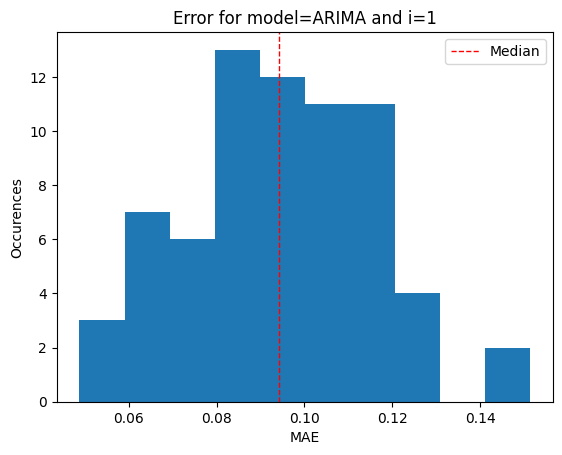

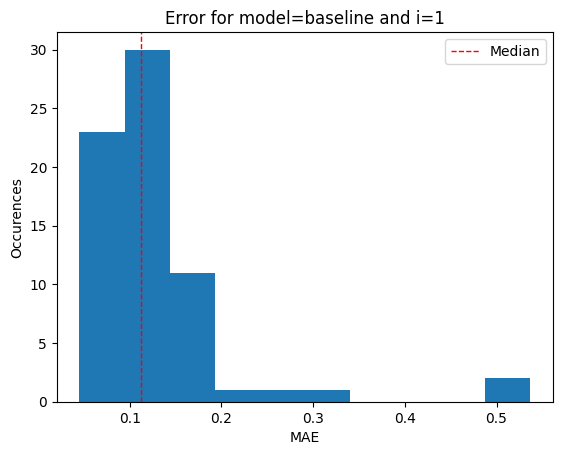

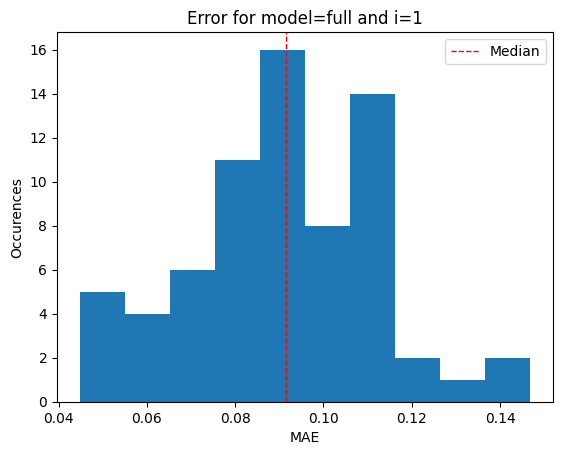

In [50]:
ARIMA_XGBoost_Errors.median_histogram(i=1)

In [51]:
ARIMA_XGBoost_Errors.wilcoxon_test(i=1, specific_model='full', name="ARIMA")

Specific model Comparison: full
\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
 & F,1 & F,2 & F,3 & F,4 \\
\hline
F,1 & \cellcolor[HTML]{cacaca} -- & \cellcolor[HTML]{e2ffca} 1.2e-12 & \cellcolor[HTML]{e2ffca} 5.3e-11 & \cellcolor[HTML]{e2ffca} 9.6e-13 \\
\hline
F,2 & \cellcolor[HTML]{e2ffca} 1.2e-12 & \cellcolor[HTML]{cacaca} -- & \cellcolor[HTML]{ffbdbd} 1.2e-01 & \cellcolor[HTML]{e2ffca} 2.1e-09 \\
\hline
F,3 & \cellcolor[HTML]{e2ffca} 5.3e-11 & \cellcolor[HTML]{ffbdbd} 1.2e-01 & \cellcolor[HTML]{cacaca} -- & \cellcolor[HTML]{e2ffca} 2.4e-10 \\
\hline
F,4 & \cellcolor[HTML]{e2ffca} 9.6e-13 & \cellcolor[HTML]{e2ffca} 2.1e-09 & \cellcolor[HTML]{e2ffca} 2.4e-10 & \cellcolor[HTML]{cacaca} -- \\
\hline
\end{tabular}
\caption{P-values from Wilcoxon signed-rank tests.}
\label{table:results}
\end{table}


/var/folders/_6/l3776shn2kq8j4f7hm3qr5bh0000gn/T/ipykernel_1845/3765975265.py:147: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result_matrix = result_matrix.applymap(lambda x: '%.1e' % x)


,"F,1","F,2","F,3","F,4"
"F,1",nan,1.2e-12,5.3e-11,9.6e-13
"F,2",1.2e-12,nan,1.2e-01,2.1e-09
"F,3",5.3e-11,1.2e-01,nan,2.4e-10
"F,4",9.6e-13,2.1e-09,2.4e-10,nan


In [52]:
ARIMA_XGBoost_Errors.wilcoxon_test(i=4)

\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
 & B,4 & A,4 & F,4 \\
\hline
B,4 & \cellcolor[HTML]{cacaca} -- & \cellcolor[HTML]{e2ffca} 4.2e-03 & \cellcolor[HTML]{e2ffca} 6.2e-05 \\
\hline
A,4 & \cellcolor[HTML]{e2ffca} 4.2e-03 & \cellcolor[HTML]{cacaca} -- & \cellcolor[HTML]{e2ffca} 2.0e-07 \\
\hline
F,4 & \cellcolor[HTML]{e2ffca} 6.2e-05 & \cellcolor[HTML]{e2ffca} 2.0e-07 & \cellcolor[HTML]{cacaca} -- \\
\hline
\end{tabular}
\caption{P-values from Wilcoxon signed-rank tests.}
\label{table:results}
\end{table}


/var/folders/_6/l3776shn2kq8j4f7hm3qr5bh0000gn/T/ipykernel_1845/3765975265.py:147: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result_matrix = result_matrix.applymap(lambda x: '%.1e' % x)


,"B,4","A,4","F,4"
"B,4",nan,4.2e-03,6.2e-05
"A,4",4.2e-03,nan,2.0e-07
"F,4",6.2e-05,2.0e-07,nan


In [53]:
def latex_table(result_matrix, alpha=0.05):
        # Prepare LaTeX table
        latex_table = "\\begin{table}[ht]\n\\centering\n\\begin{tabular}{|" + "c|" * (len(result_matrix.columns) + 1) + "}\n\\hline\n"
        
        # Header row
        latex_table += " & " + " & ".join(result_matrix.columns) + " \\\\\n\\hline\n"
        
        # Data rows
        for i, row_name in enumerate(result_matrix.index):
            latex_table += row_name
            for j, col_name in enumerate(result_matrix.columns):
                if i == j:
                    # Diagonal cell
                    latex_table += " & \\cellcolor[HTML]{cacaca} --"
                else:
                    p_value = float(result_matrix.loc[row_name, col_name])
                    if p_value < alpha:
                        color = "cellcolor[HTML]{e2ffca}"  # Light green
                    else:
                        color = "cellcolor[HTML]{ffbdbd}"  # Light red
                    latex_table += f" & \\{color} {'%.1e' % p_value}"
            latex_table += " \\\\\n\\hline\n"
        
        latex_table += "\\end{tabular}\n\\caption{P-values from Wilcoxon signed-rank tests.}\n\\label{table:results}\n\\end{table}"
        
        print(latex_table)



def wilcoxon_test_across_datasets(errors, specific_model='full1', i=1, alpha=0.05, name=''):
    model_columns = ['O', 'OL', 'S', 'SL']
    comparisons = [(j, k) for j in range(len(model_columns)) for k in range(j + 1, len(model_columns))]

    result_matrix = pd.DataFrame(columns=model_columns, index=model_columns)

    for (model_name1, model_name2) in comparisons:
        differences = np.array(errors[model_name1].data[f'Error_{specific_model}'] - errors[model_name2].data[f'Error_{specific_model}'])
        rounded_differences = np.round(differences, decimals=5)
        # Perform Wilcoxon signed-rank tests
        statistic, p_value = wilcoxon(rounded_differences)
        #if p_value < alpha:
        #    result_matrix.loc[model_name1, model_name2] = p_value
        #    result_matrix.loc[model_name2, model_name1] = p_value
        result_matrix.iloc[model_name1, model_name2] = p_value
        result_matrix.iloc[model_name2, model_name1] = p_value

    #for model_name in model_columns:
    #    result_matrix = result_matrix.rename(index={model_name: model_name[0].upper() + ',' + model_name[-1]}, 
    #                                            columns={model_name: model_name[0].upper() + ',' + model_name[-1]})
                                            
    result_matrix = result_matrix.applymap(lambda x: '%.1e' % x)
    latex_table(result_matrix, alpha=alpha)
    #result_matrix.to_csv(f'Results/Wilcoxon{name}.csv', float_format='%.2e')
    return result_matrix

In [54]:
XGBoost_Cleaned = Errors('Cleaned', 'XGBoost', 20)
XGBoost_Cleaned_lagged = Errors('Cleaned_lagged', 'XGBoost', 20)
XGBoost_Cleaned_simple = Errors('Cleaned_simple', 'XGBoost', 20)
XGBoost_Cleaned_simple_lagged = Errors('Cleaned_simple_lagged', 'XGBoost', 20)

In [55]:
wilcoxon_test_across_datasets([XGBoost_Cleaned, XGBoost_Cleaned_lagged, XGBoost_Cleaned_simple, XGBoost_Cleaned_simple_lagged])

\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
 & O & OL & S & SL \\
\hline
O & \cellcolor[HTML]{cacaca} -- & \cellcolor[HTML]{ffbdbd} 3.8e-01 & \cellcolor[HTML]{e2ffca} 2.1e-12 & \cellcolor[HTML]{e2ffca} 3.9e-06 \\
\hline
OL & \cellcolor[HTML]{ffbdbd} 3.8e-01 & \cellcolor[HTML]{cacaca} -- & \cellcolor[HTML]{e2ffca} 1.1e-12 & \cellcolor[HTML]{e2ffca} 4.2e-09 \\
\hline
S & \cellcolor[HTML]{e2ffca} 2.1e-12 & \cellcolor[HTML]{e2ffca} 1.1e-12 & \cellcolor[HTML]{cacaca} -- & \cellcolor[HTML]{e2ffca} 9.6e-13 \\
\hline
SL & \cellcolor[HTML]{e2ffca} 3.9e-06 & \cellcolor[HTML]{e2ffca} 4.2e-09 & \cellcolor[HTML]{e2ffca} 9.6e-13 & \cellcolor[HTML]{cacaca} -- \\
\hline
\end{tabular}
\caption{P-values from Wilcoxon signed-rank tests.}
\label{table:results}
\end{table}


/var/folders/_6/l3776shn2kq8j4f7hm3qr5bh0000gn/T/ipykernel_1845/768438759.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result_matrix = result_matrix.applymap(lambda x: '%.1e' % x)


,O,OL,S,SL
O,nan,3.8e-01,2.1e-12,3.9e-06
OL,3.8e-01,nan,1.1e-12,4.2e-09
S,2.1e-12,1.1e-12,nan,9.6e-13
SL,3.9e-06,4.2e-09,9.6e-13,nan


### Error plots

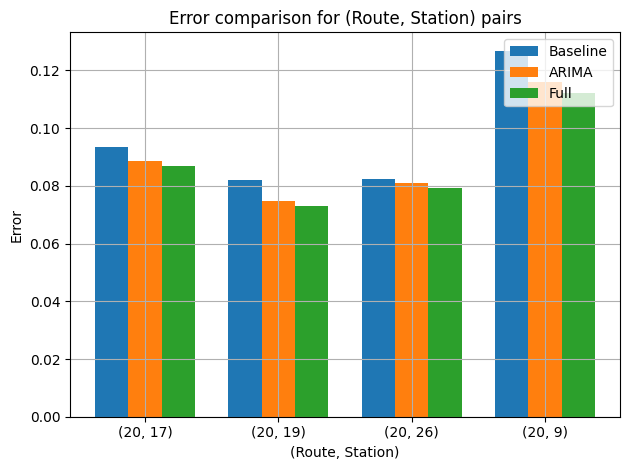

In [56]:
ARIMA_CatBoost_Errors.error_function()

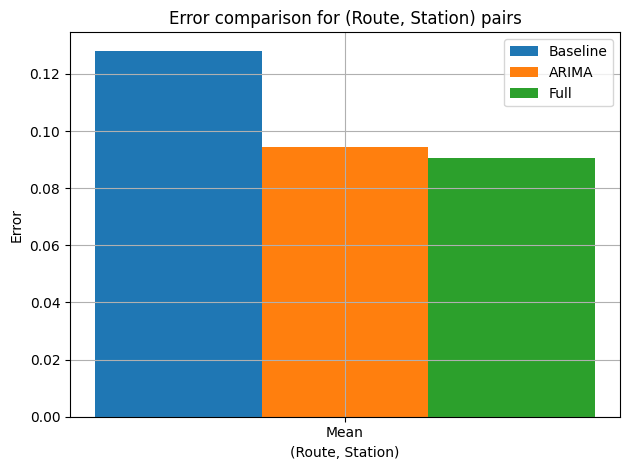

,Error_baseline1,Error_ARIMA1,Error_full1,Error_baseline2,Error_ARIMA2,Error_full2,Error_baseline3,Error_ARIMA3,Error_full3,Error_baseline4,Error_ARIMA4,Error_full4,route_station
0,0.12814,0.094304,0.090708,0.128163,0.101506,0.099079,0.128178,0.103822,0.100298,0.128184,0.106346,0.103849,Mean


In [57]:
ARIMA_XGBoost_Errors.error_function(use_mean=True)

In [58]:
np.mean([0.094304, 0.101506, 0.103822, 0.106346])

0.1014945

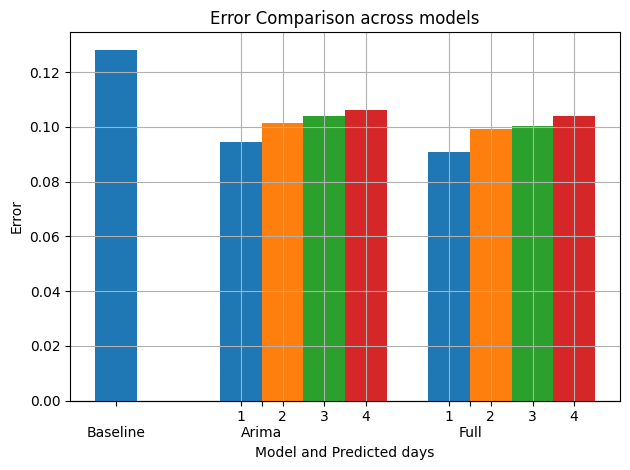

In [59]:
ARIMA_XGBoost_Errors.error_function(use_across_days=True)
# Makes sense: ARIMA is not affected by shifting (it is only in X). The GBDT has difficulties knowing the error arima will make regardless of extra info in X - totally make sense. 

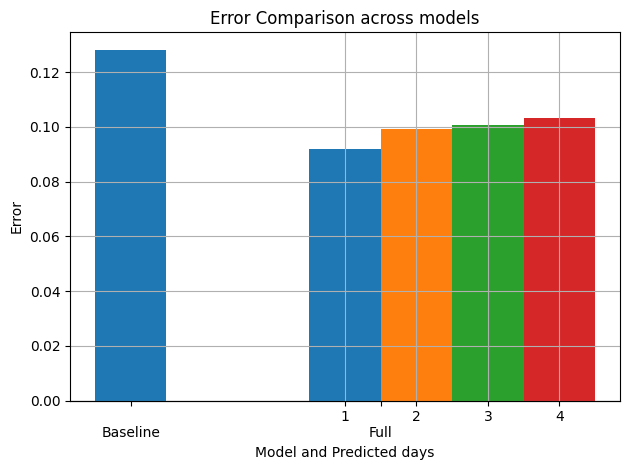

In [60]:
XGBoost_Errors.error_function(use_across_days=True) # More errors here because only XGboost. expected!

In [61]:
def plot_columns(data_classes, column, column_arima=None):
    datasets = data_classes

    plt.figure(figsize=(10,7))
    bar_width = 0.15
    arima_found=False
    plt.bar([bar_width], (pd.DataFrame(datasets[0].data.mean(axis=0, numeric_only=True)).T.assign(route_station='Mean'))['Error_baseline1'], bar_width, label='Baseline')
    counter = 0
    for i, (dataset) in enumerate(datasets):
        dataset_df = (pd.DataFrame(dataset.data.mean(axis=0, numeric_only=True)).T.assign(route_station='Mean')).sort_values(by='route_station')
        plt.bar([(counter+2) * bar_width], dataset_df[column].values, bar_width, label=dataset.model_name)
        counter += 1
        if column_arima in dataset_df.columns and not arima_found:
            plt.bar([(counter+2) * bar_width], dataset_df[column_arima].values, bar_width, label='ARIMA')
            counter += 1
            arima_found=True
        plt.xticks([counter * bar_width-bar_width], dataset_df['route_station'])
    
    plt.legend()
    plt.title(f'Error full on {dataset.dataset_name} data')
    plt.grid()


In [62]:
XGBoost_Errors.data.iloc[:,1:].mean(axis=0) # 0.092052
#CatBoost_Errors.data.iloc[:,1:].mean(axis=0) #0.091797

Error_baseline1     0.12814
Error_ARIMA1            NaN
Error_full1        0.092052
Error_baseline2    0.128163
Error_ARIMA2            NaN
Error_full2        0.099134
Error_baseline3    0.128178
Error_ARIMA3            NaN
Error_full3        0.100546
Error_baseline4    0.128184
Error_ARIMA4            NaN
Error_full4        0.103084
dtype: object

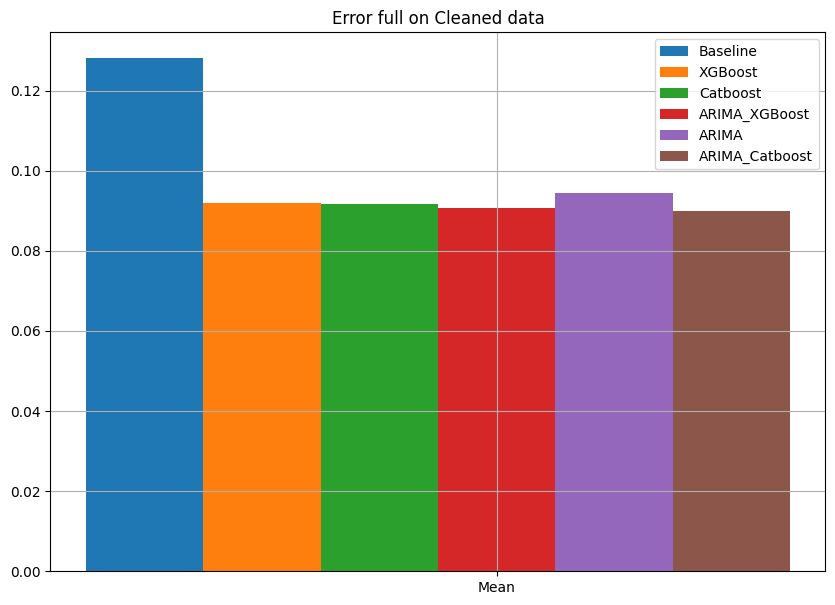

In [63]:
plot_columns([XGBoost_Errors, CatBoost_Errors, ARIMA_XGBoost_Errors, ARIMA_CatBoost_Errors], 'Error_full1', column_arima='Error_ARIMA1')

In [64]:
XGBoost_Errors_Cleaned = Errors('Cleaned', 'XGBoost', 20)
XGBoost_Errors_Cleaned_lagged = Errors('Cleaned_lagged', 'XGBoost', 20)
XGBoost_Errors_Cleaned_simple = Errors('Cleaned_simple', 'XGBoost', 20)
XGBoost_Errors_Cleaned_simple_lagged = Errors('Cleaned_simple_lagged', 'XGBoost', 20)

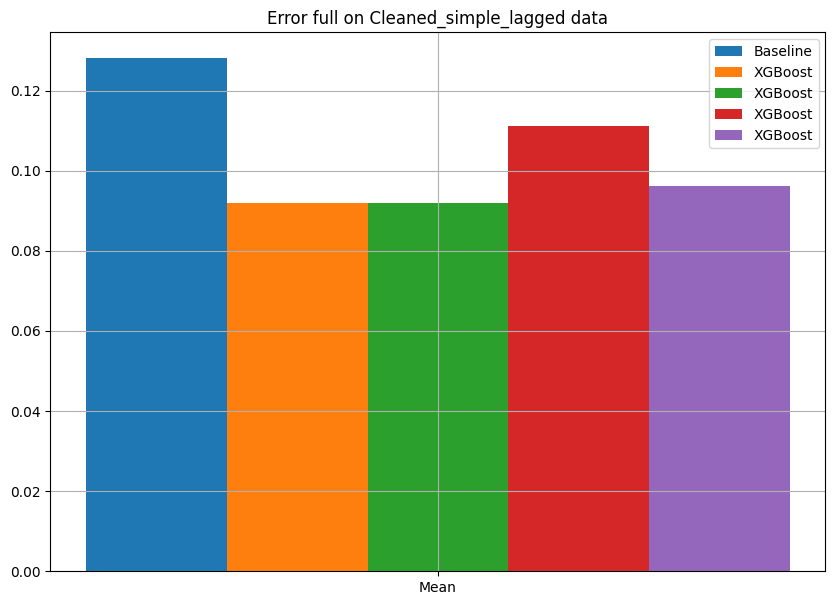

In [65]:
# Across datasets. Pænere potentielt!
plot_columns([XGBoost_Errors_Cleaned, XGBoost_Errors_Cleaned_lagged, XGBoost_Errors_Cleaned_simple, XGBoost_Errors_Cleaned_simple_lagged], 'Error_full1')

In [66]:
from matplotlib.ticker import MaxNLocator
import ast

class CV_score(Results):
    def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
        super().__init__('CV_score', dataset_name, model_names, specific_train_route, x)

    def CV_score_histplot(self, i=1, use_extracted=True):
        data = self.data
        if use_extracted: data = self.data_route
        for _, row in data.iterrows():
            route_station = ast.literal_eval(row['route_station'])
            cv_scores_full = row[f'CV_score_full{i}']
            cv_scores_baseline = row[f'CV_score_baseline{i}']
            cv_scores_arima = cv_scores_arima=row.get(f'CV_score_ARIMA{i}', pd.DataFrame())
            max_score = max(max(cv_scores_baseline), max(cv_scores_full))
            min_score = min(min(cv_scores_baseline), min(cv_scores_full))
            
            arima_check = not cv_scores_arima.empty

            if arima_check:
                max_score = max(max_score, max(cv_scores_arima))
                min_score = min(min_score, min(cv_scores_arima))
            
            num_bins = 15
            bins = np.linspace(min_score, max_score, num_bins)
            
            plt.hist(cv_scores_full, edgecolor="black", bins=bins, alpha=0.5, label='Full')

            
            if arima_check:
                plt.hist(cv_scores_arima, edgecolor="black", bins=bins, alpha=0.5, label='ARIMA')
            
            plt.hist(cv_scores_baseline, edgecolor="black", bins=bins, alpha=0.5, label='Baseline')
            
            
            plt.title(f'Cross Validation Error for route {route_station[0]} and station {route_station[1]}')
            plt.xlabel('MAE')
            plt.ylabel('Occurrences')
            plt.legend(loc='upper right')
            plt.grid()
            plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True)) # only integer ticks in y-axis
            plt.show()
        
    def CV_score_lineplot(self, i=1, use_extracted=True, initial_start=30):
            data = self.data
            if use_extracted: data = self.data_route
            for _, row in data.iterrows():
                route_station = ast.literal_eval(row['route_station'])
                cv_scores_full = row[f'CV_score_full{i}']
                cv_scores_baseline = row[f'CV_score_baseline{i}']
                cv_scores_arima = cv_scores_arima=row.get(f'CV_score_ARIMA{i}', pd.DataFrame())
                plt.plot(cv_scores_baseline[-initial_start:], label='Baseline')
                
                if not cv_scores_arima.empty:
                    plt.plot(cv_scores_arima[-initial_start:], label='ARIMA')

                plt.plot(cv_scores_full[-initial_start:], label='Full')
                
                plt.title(f'Cross Validation Error for route {route_station[0]} and station {route_station[1]}')
                plt.xlabel('Data points')
                plt.ylabel('MAE')
                plt.legend(loc='upper right')
                plt.grid()
                plt.show()
    def CV_score_function(self, use_hist=False, use_line=False, use_extracted=True, initial_start=30):
        if use_hist:
            self.CV_score_histplot(use_extracted = use_extracted)
        if use_line:
            self.CV_score_lineplot(use_extracted=use_extracted, initial_start=initial_start)
        

In [67]:
ARIMA_XGBoost_CV_scores = CV_score('Cleaned', 'ARIMA_XGBoost', 20)
ARIMA_XGBoost_CV_scores.data['CV_score_baseline1']

0     0      0.110068
1      0.099001
2      0.10794...
1     0      0.080081
1      0.027044
2      0.21696...
2     0      0.284738
1      0.126594
2      0.31353...
3     0      0.116781
1      0.088728
2      0.12268...
4     0      0.068330
1      0.068299
2      0.16273...
                            ...                        
64    0      0.020426
1      0.080417
2      0.03138...
65    0      0.045486
1      0.118465
2      0.02658...
66    0      0.046111
1      0.054090
2      0.11006...
67    0      0.092812
1      0.092769
2      0.01572...
68    0      0.039800
1      0.039781
2      0.08523...
Name: CV_score_baseline1, Length: 69, dtype: object

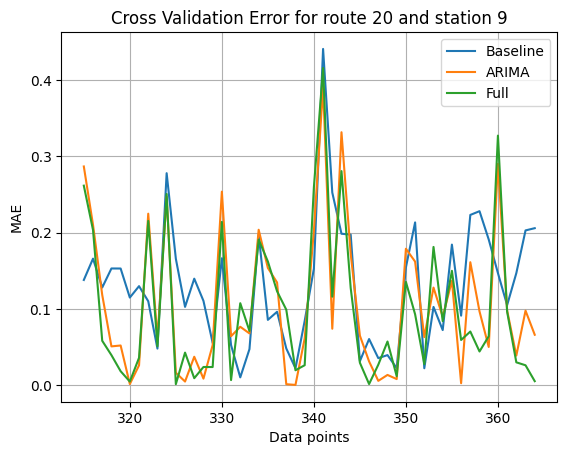

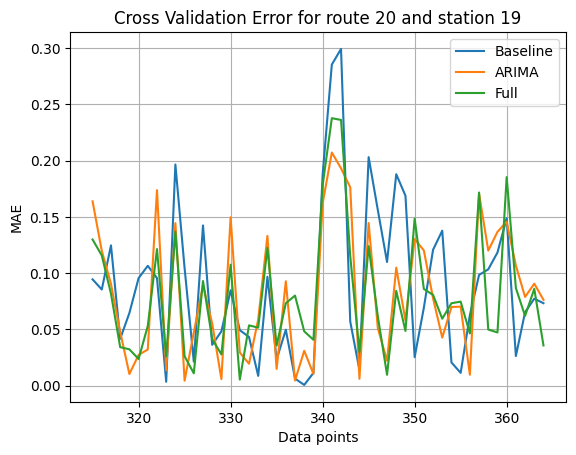

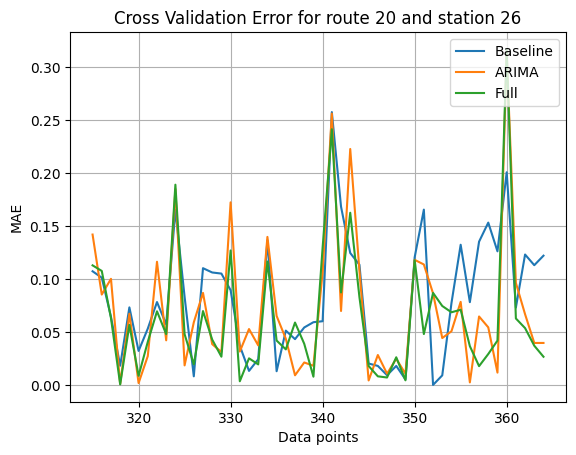

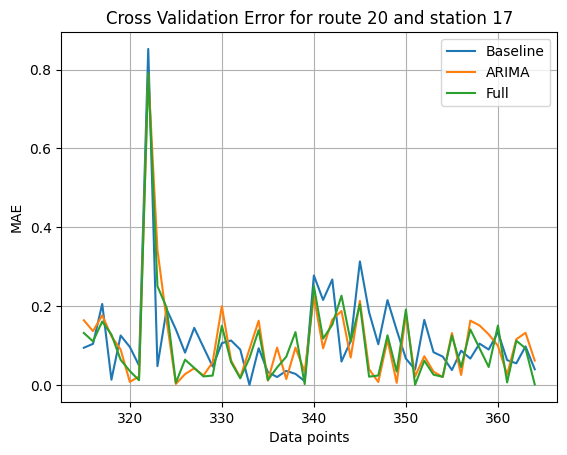

In [68]:
ARIMA_XGBoost_CV_scores.CV_score_function(use_line=True, initial_start=50)

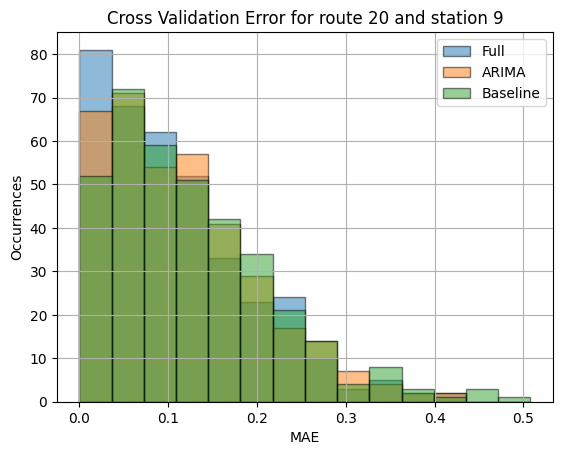

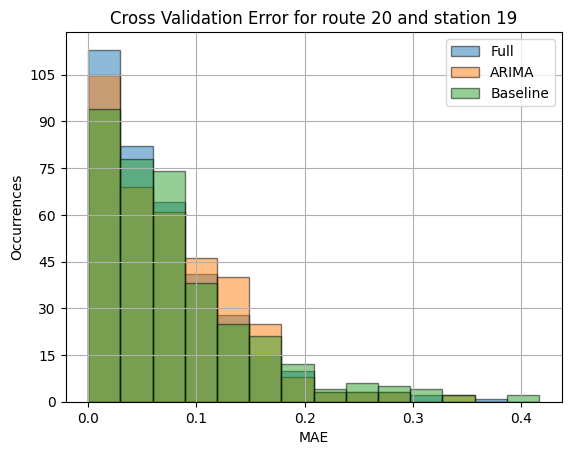

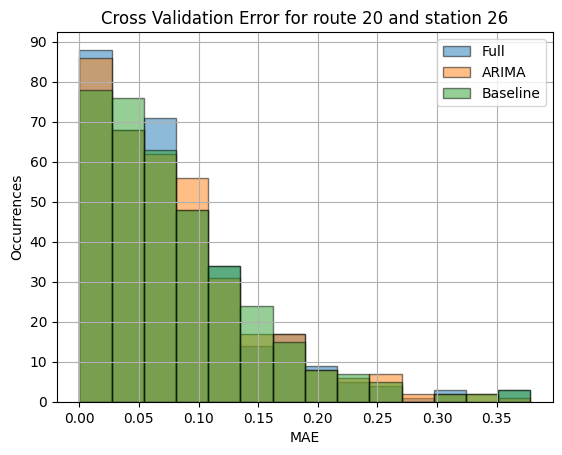

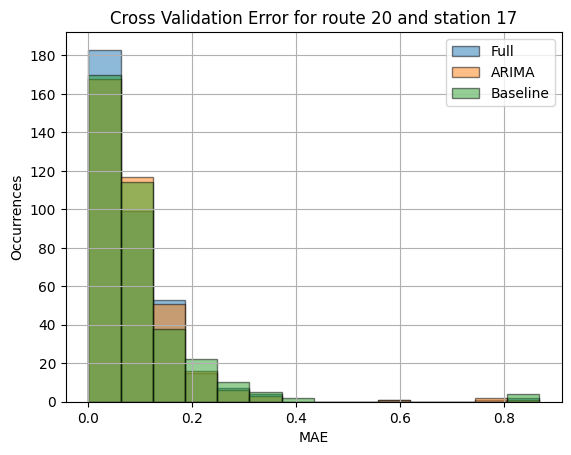

In [69]:
ARIMA_XGBoost_CV_scores.CV_score_function(use_hist=True)

In [70]:
class Predictions(Results):
    def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
        super().__init__('Predictions', dataset_name, model_names, specific_train_route, x)

    def prediction_plot(self, i, initial_start, arima=False, use_extracted=True):
        data = self.data
        if use_extracted: data = self.data_route
        initial_start = initial_start
        for row_no, row in data.iterrows():
            y_test = row[f'y_true{i}']
            # Extract corresponding predictions from predictions DataFrame
            predictions_full = row[f'Predictions_full{i}']
            # Dates: 
            x_dates = np.arange(initial_start)
            route_station = row['route_station']
            plt.plot(x_dates[-initial_start:], y_test[-initial_start:], color='#33a02c', label='Test Data')
            if arima:
                predictions_arima = row.get(f'Predictions_ARIMA{i}', [None])
                plt.plot(x_dates[-initial_start:], predictions_arima[-initial_start:], color='#1E77B4', marker='x', label='ARIMA Predictions')
            plt.plot(x_dates[-initial_start:], predictions_full[-initial_start:], color='#FD7E0E', marker='x', label='Full Predictions')
            plt.title(f'Route/station {route_station}: Predictions & True Value')
            plt.xlabel('Observations')
            plt.ylabel('Train punctuality')
            plt.xticks(x_dates[-initial_start::10], rotation=45)
            plt.legend(loc='lower right')
            plt.grid()
            plt.show()
    def prediction_function(self, i, initial_start, arima, use_extracted):
        self.prediction_plot(i, initial_start, arima, use_extracted)

In [71]:
ARIMA_XGBoost_Predictions = Predictions('Cleaned', 'ARIMA_XGBoost', 20)
#ARIMA_XGBoost_Predictions.data

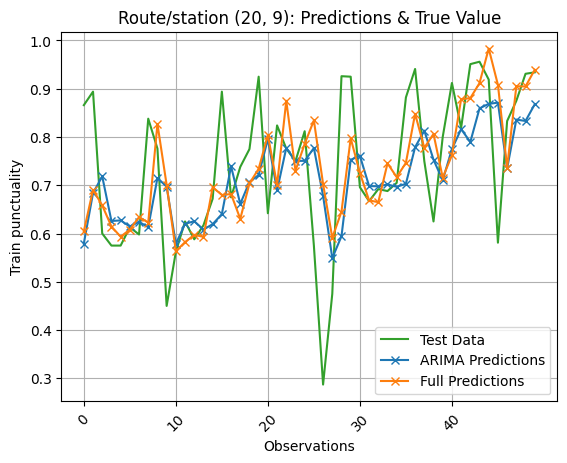

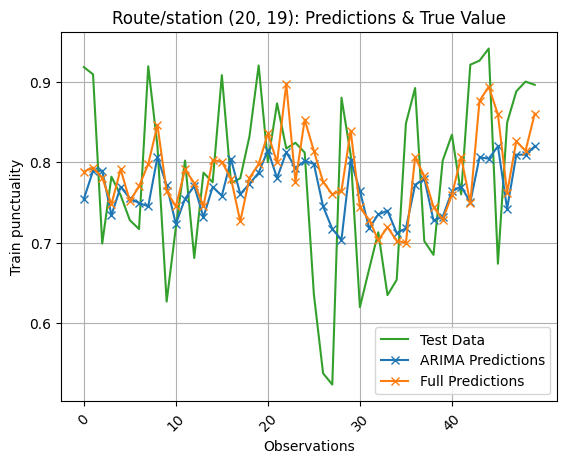

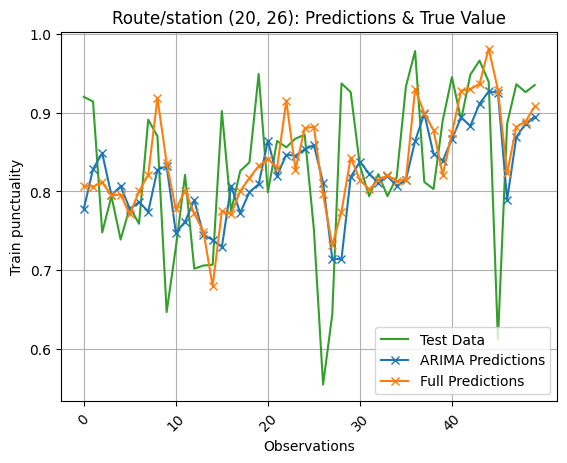

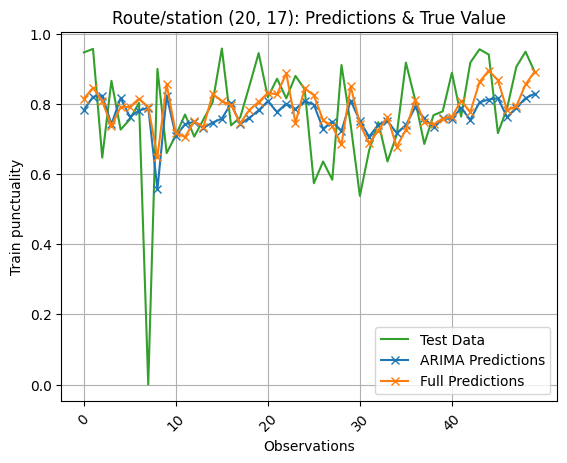

In [72]:
ARIMA_XGBoost_Predictions.prediction_function(i=1, initial_start=50, arima=True, use_extracted=True)

In [73]:
# Perspektivering til BaneDanmark.
prediction_series = ARIMA_XGBoost_Predictions.data['Predictions_full1']
true_series = ARIMA_XGBoost_Predictions.data['y_true1']
prediction_mean_series = prediction_series.apply(lambda x: x.mean())
true_mean_series = true_series.apply(lambda x: x.mean())
prediction_overall_mean = prediction_mean_series.mean()
true_overall_mean = true_mean_series.mean()
print(f"True mean: {true_overall_mean}. Prediction mean: {prediction_overall_mean}")

True mean: 0.7974136192177883. Prediction mean: 0.8129035338258516


In [74]:
import shap
import textwrap
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator



class FeatureImportance(Results):
      def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
         super().__init__('FI', dataset_name, model_names, specific_train_route, x)
         self.dataset = pd.read_csv(f'Data/{self.dataset_name}_data.csv')

         self.mean_matrix_all = self.mean_matrix_calculation()
         self.mean_matrix_route = self.mean_matrix_calculation(use_extracted=True)
         self.feature_importance_path = f'Results/SHAP_consistency/{dataset_name}/{model_names}/*feature_importances365.csv'
         self.data_consistency = self.data_from_files_consistency()
         if len(self.data_consistency) != 0:
               self.mean_matrix_consistency = self.mean_matrix_calculation_consistency()

      def data_from_files(self, relative_path, measure):
            file_list_results = glob.glob(relative_path)
        
            result_df = pd.DataFrame()

            for file in file_list_results:
                  index_start = len(relative_path.split('*')[0])
                  data_from_file = pd.read_csv(file)
                  file_dict = {}
                  file_dict['route_station'] = file[index_start:].split('_')[0]

                  file_dict['Feature_importances'] = [data_from_file.to_numpy().T]
                  result_df = pd.concat([result_df, pd.DataFrame(file_dict, index=[0])], ignore_index=True)
            return result_df
      
      def data_from_files_consistency(self):
            file_list_results = glob.glob(self.feature_importance_path)

            result_df = pd.DataFrame()

            for file in file_list_results:
                  index_start = len(self.feature_importance_path.split('*')[0])
                  data_from_file = pd.read_csv(file)
                  file_dict = {}
                  file_dict['route_station'] = file[index_start:].split('_')[0] + file[index_start:].split('_')[1][-1]

                  file_dict['Feature_importances'] = [data_from_file.to_numpy().T]
                  result_df = pd.concat([result_df, pd.DataFrame(file_dict, index=[0])], ignore_index=True)
            return result_df

      
      def mean_matrix_calculation(self, use_extracted = False):
            data = self.data
            if use_extracted:
                  data = self.data_route
            mean_matrix = np.zeros(data.iloc[0,1].shape)
            for i in range(0,len(data)):
                  mean_matrix += data.iloc[i,1]
            mean_matrix = mean_matrix / (i+1)
            return mean_matrix
      
      def mean_matrix_calculation_consistency(self):
            data = self.data_consistency
            mean_matrix = np.zeros((data.iloc[0,1].shape[0], data.iloc[0,1].shape[1], 6))
            for i in range(0,len(data)):
                  period = int(data.iloc[i,0][-1])
                  mean_matrix[:,:,period] += data.iloc[i,1]
            mean_matrix = mean_matrix / (i+1)
            return mean_matrix

      def plot_consistency1(self):
            periods = [f'20{17+i}'for i in range(6)]
            for i in range(self.mean_matrix_consistency.shape[2]):
                  new_mean_matrix=np.abs(self.mean_matrix_consistency[:,:,i]).mean(0)
                  data_used = self.dataset.iloc[:, 2:]
                  feature_importance = pd.DataFrame(list(zip(data_used.columns,new_mean_matrix)),columns=['col_name','feature_importance_vals'])
                  feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
                  plt.barh(feature_importance.iloc[:10,0].values, feature_importance.iloc[:10,1].values, label=periods[i])
                  plt.xticks(rotation=-45)
                  plt.legend()
                  plt.grid()
                  plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

                  #self.plot_shap_summary(new_mean_matrix=self.mean_matrix_consistency[:,:,i])
            #plt.show()

      def plot_consistency(self):
            periods = [f'20{17+i}' for i in range(6)]
            top_features = []

            # Extract top 10 features for each period
            for i in range(self.mean_matrix_consistency.shape[2]):
                  new_mean_matrix = np.abs(self.mean_matrix_consistency[:,:,i]).mean(0)
                  data_used = self.dataset.iloc[:, 2:]
                  feature_importance = pd.DataFrame(list(zip(data_used.columns, new_mean_matrix)), columns=['col_name', 'feature_importance_vals'])
                  feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
                  top_features.append(feature_importance.iloc[:10, 0].values)

            # Create a DataFrame to store the presence of top features across periods
            feature_presence = pd.DataFrame(index=np.unique(np.concatenate(top_features)), columns=periods)
            feature_presence = feature_presence.fillna(0)

            # Update the presence matrix with placement
            for i, features in enumerate(top_features):
                  for rank, feature in enumerate(features):
                        feature_presence.loc[feature, periods[i]] = rank + 1  # Rank starts from 1
            # Create custom colormap with white for 0, dark for 1, and brighter colors for higher ranks
            cmap_colors = [(0.5, 0.5, 1)]  # White color for 0
            for i in range(11, 1, -1):
                  brightness = 1 - (i / 11)  # Calculate brightness (0 for rank 1, 1 for rank 10)
                  cmap_colors.append((brightness, brightness, 1))  # Blueish color with varying brightness
            cmap = LinearSegmentedColormap.from_list('custom_cmap', cmap_colors)

            # Plot heatmap with actual placement
            plt.figure(figsize=(10, 8))
            sns.heatmap(feature_presence, cmap=cmap, annot=True, cbar=True, center=5, fmt= ".0f", mask=(feature_presence == 0))
            plt.title('Top Features Across Time Periods')
            plt.xlabel('Time Period')
            plt.ylabel('Top Features')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
      
      def plot_shap_summary(self, plot_type='dot', new_mean_matrix=None, use_extracted = False):
            shap_values = self.mean_matrix_all
            if use_extracted:
                  shap_values = self.mean_matrix_route
            if new_mean_matrix is not None:
                  shap_values = new_mean_matrix

            data_used = self.dataset.iloc[-len(shap_values)-3:-3, 2:] # used only the 365 last datapoints and not the last 3 ones because horizon = 4, columns excluded are date and train punctuality
            shap.summary_plot(shap_values, data_used, show=False, max_display=10, plot_type=plot_type, plot_size=(0.1,16)) #  feature_names=np.array(feature_names).reshape(211,1)
            plt.gcf().set_size_inches(18, 10)

            ax = plt.gca()
            tick_labels = ax.get_yticklabels()
            # Wrap long tick labels to the next line
            max_chars_per_line = 23  # Define the maximum number of characters per line
            wrapped_tick_labels = []
            for label in tick_labels:
                  text = label.get_text()
                  # Find the nearest underscore within the specified range
                  underscore_index = min(max_chars_per_line, len(text))  # Initialize with max_chars_per_line
                  for i in range(max_chars_per_line - 5, len(text)):
                        if text[i] == '_':
                              underscore_index = i
                              break
                  wrapped_tick_labels.append(textwrap.fill(text, underscore_index+1))

            # Set the wrapped tick labels
            ax.set_yticklabels(wrapped_tick_labels[:len(shap_values)])  # Ensure the number of labels matches the number of shap values


            plt.yticks(fontsize = 12)
            plt.xticks(fontsize=12)
            plt.show()

In [75]:
FI_Cleaned_lagged_ARIMA_XGBoost = FeatureImportance('Cleaned_lagged', 'XGBoost', 20)
FI_Cleaned_lagged_ARIMA_XGBoost.mean_matrix_all.shape

(365, 275)

/var/folders/_6/l3776shn2kq8j4f7hm3qr5bh0000gn/T/ipykernel_1845/823945825.py:101: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feature_presence = feature_presence.fillna(0)


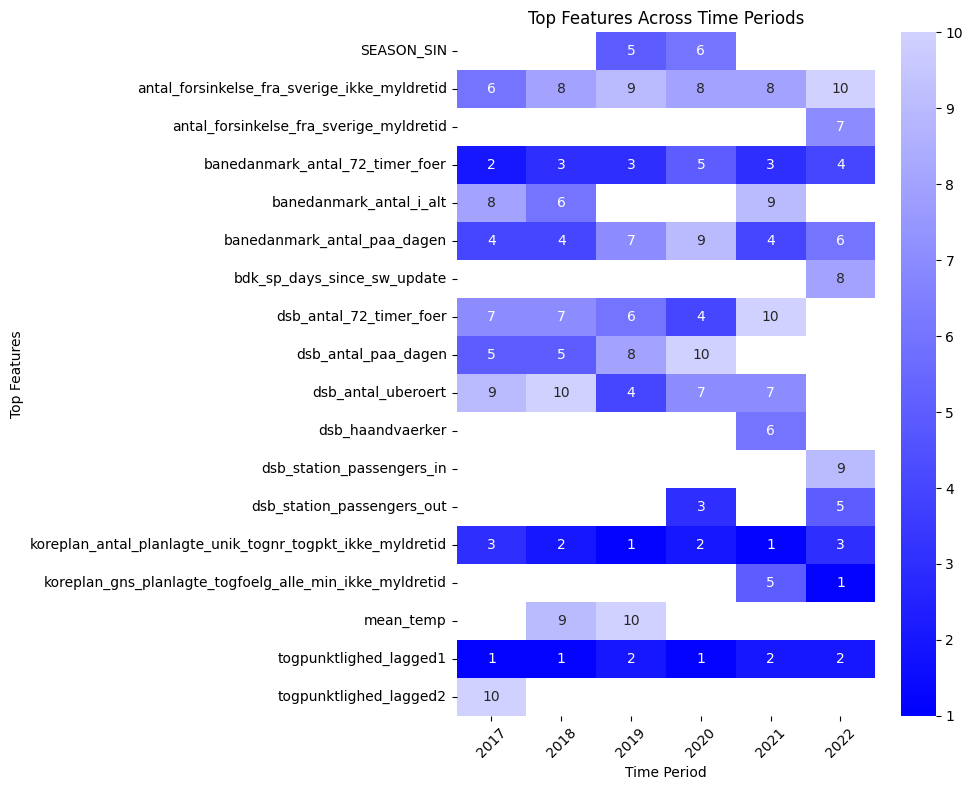

In [76]:
FI_Cleaned_lagged_ARIMA_XGBoost.mean_matrix_consistency.shape
FI_Cleaned_lagged_ARIMA_XGBoost.plot_consistency()

In [77]:
FI_Cleaned_lagged_ARIMA_XGBoost.mean_matrix_consistency[:,:,0].shape

(365, 275)

/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/shap/plots/_beeswarm.py:962: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


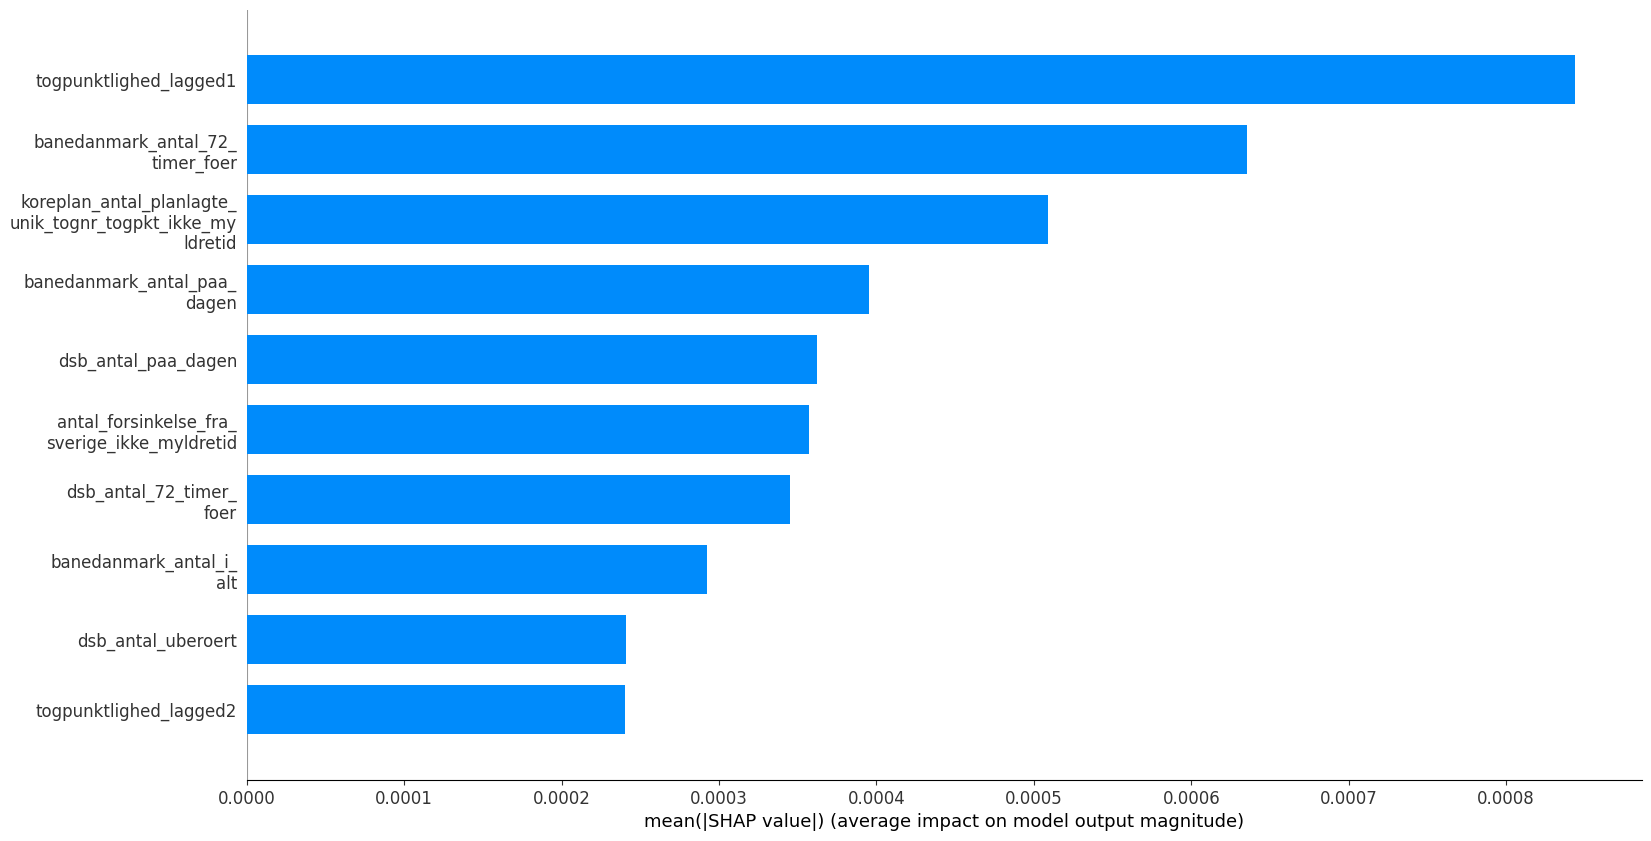

In [78]:
FI_Cleaned_lagged_ARIMA_XGBoost.plot_shap_summary(new_mean_matrix=FI_Cleaned_lagged_ARIMA_XGBoost.mean_matrix_consistency[:,:,0], plot_type='bar')

/Users/clarasofiechristiansen/anaconda3/envs/DSB_Bachelorprojekt/lib/python3.11/site-packages/shap/plots/_beeswarm.py:962: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


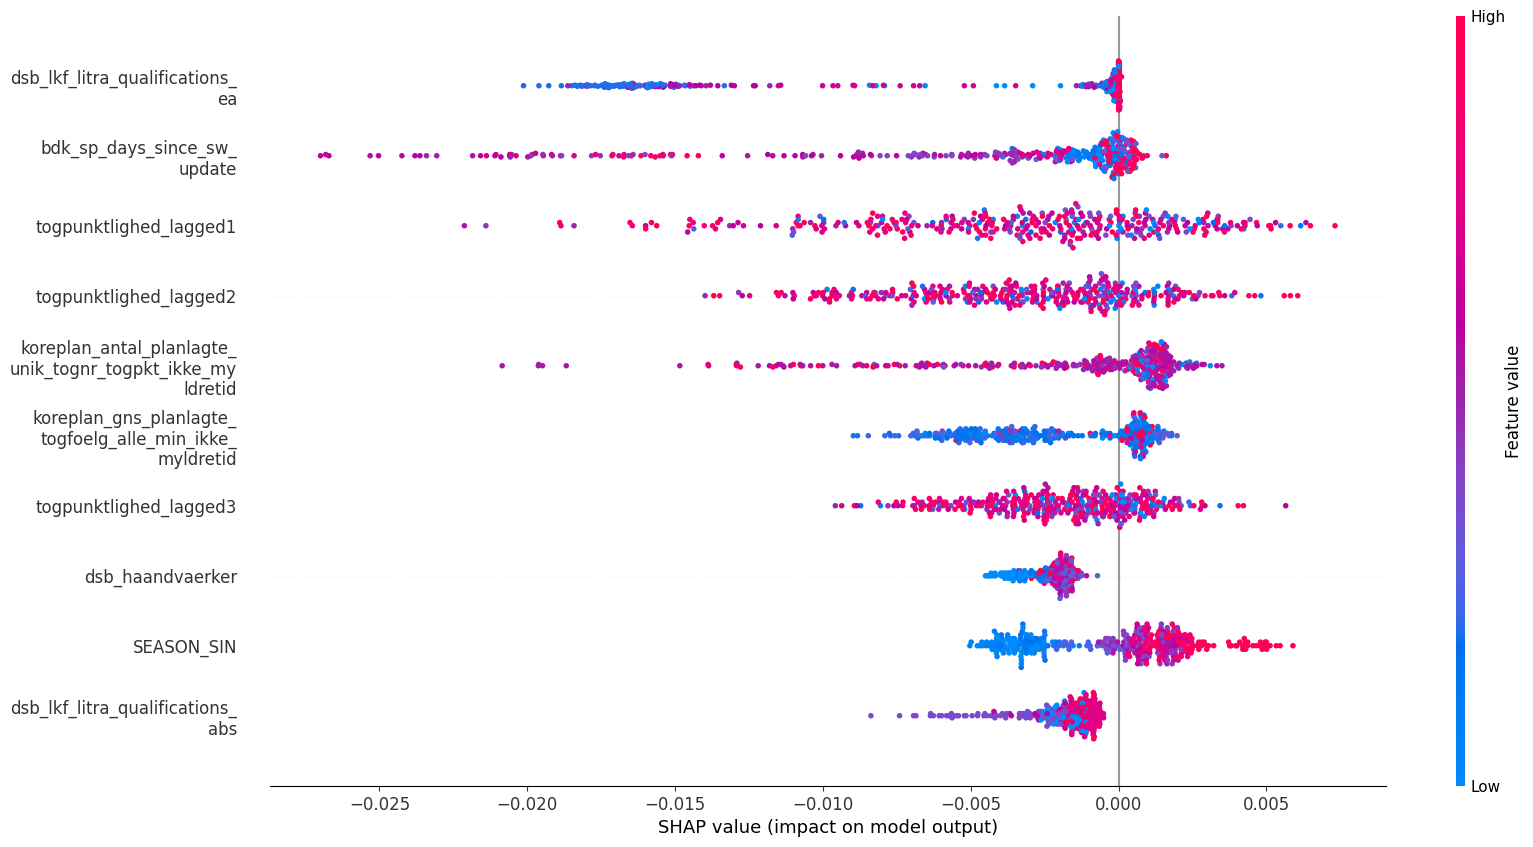

In [79]:
FI_Cleaned_lagged_ARIMA_XGBoost.plot_shap_summary(plot_type='dot')